### Convolutional Neural Networks: Application
    Welcome to Course 4's second assignment! In this notebook, you will:

    - Create a mood classifer using the TF Keras Sequential API
    - Build a ConvNet to identify sign language digits using the TF Keras Functional API
    
    After this assignment you will be able to:

        - Build and train a ConvNet in TensorFlow for a binary classification problem
        - Build and train a ConvNet in TensorFlow for a multiclass classification problem
        - Explain different use cases for the Sequential and Functional APIs
    
    To complete this assignment, you should already be familiar with TensorFlow. If you are not, please refer back to the TensorFlow Tutorial of the third week of Course 2 ("Improving deep neural networks").

**Table of Contents**
- 1 - Packages
    - 1.1 - Load the Data and Split the Data into Train/Test Sets
- 2 - Layers in TF Keras
- 3 - The Sequential API
    - 3.1 - Create the Sequential Model
        - Exercise 1 - happyModel
    - 3.2 - Train and Evaluate the Model
- 4 - The Functional API
    - 4.1 - Load the SIGNS Dataset
    - 4.2 - Split the Data into Train/Test Sets
    - 4.3 - Forward Propagation
        - Exercise 2 - convolutional_model
    - 4.4 - Train the Model
- 5 - History Object
- 6 - Bibliography

### Packages

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import h5py

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, ZeroPadding2D, Conv2D, BatchNormalization, ReLU, Dropout, MaxPooling2D, AveragePooling2D, Flatten, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.python.framework import ops

from termcolor import colored

%matplotlib inline
np.random.seed(1)

from tensorflow.keras.utils import set_random_seed
set_random_seed(1) #to handle randomness with tf models

### 1.1 - Load the Data and Split the Data into Train/Test Sets
    You'll be using the Happy House dataset for this part of the assignment, which contains images of peoples' faces. Your task will be to build a ConvNet that determines whether the people in the images are smiling or not -- because they only get to enter the house if they're smiling!

In [23]:
def load_happy_dataset():
    train_data_orig = h5py.File("./data/train_happy.h5", "r")
    train_data_X = np.array(train_data_orig["train_set_x"]) #not converting to array will give dataset of type <class 'h5py._hl.dataset.Dataset'>
    train_data_Y = np.array(train_data_orig["train_set_y"])
    train_data_Y = train_data_Y.reshape((1, train_data_Y.shape[0])) #teshaping Y
    
    test_data_orig = h5py.File("./data/test_happy.h5", "r")
    test_data_X = np.array(test_data_orig["test_set_x"])
    test_data_Y = np.array(test_data_orig["test_set_y"])
    test_data_Y = test_data_Y.reshape((1, test_data_Y.shape[0])) #reshaping Y
    
    classes = np.array(test_data_orig["list_classes"])
    
    return train_data_X, test_data_X, train_data_Y, test_data_Y, classes
    
X_train_orig, X_test_orig, Y_train_orig, Y_test_orig, classes = load_happy_dataset()

In [25]:
print ("number of training examples = " + str(X_train_orig.shape[0]))
print ("number of test examples = " + str(X_test_orig.shape[0]))
print ("X_train shape: " + str(X_train_orig.shape))
print ("Y_train shape: " + str(Y_train_orig.shape))
print ("X_test shape: " + str(X_test_orig.shape))
print ("Y_test shape: " + str(Y_test_orig.shape))

#notice, we are not actually reshaping the X like we did earlier, 
#cuz in cnn we deal with images without flattening and then we flatten it at the end

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (1, 600)
X_test shape: (150, 64, 64, 3)
Y_test shape: (1, 150)


In [27]:
#Preprocessing the data

#Normalizing the input data
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

#Reshaping the Y to have usual shape (m, 1) instead of Deep L shape (1, m) bcz tf follows usual shape

Y_train = Y_train_orig.reshape((Y_train_orig.shape[1], 1))
Y_test = Y_test_orig.reshape((Y_test_orig.shape[1], 1))

print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


    You can display the images contained in the dataset. Images are 64x64 pixels in RGB format (3 channels).

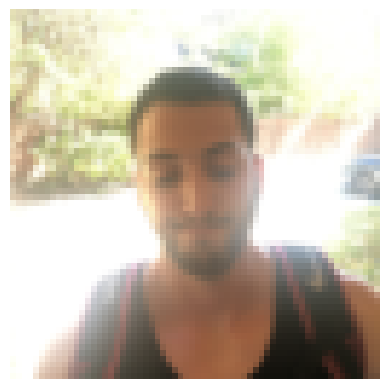

In [33]:
index = 124
plt.imshow(X_train[index]) #display sample training image
plt.axis("off")
plt.show()

### 2 - Layers in TF Keras
    In the previous assignment, you created layers manually in numpy. In TF Keras, you don't have to write code directly to create layers. Rather, TF Keras has pre-defined layers you can use.

    When you create a layer in TF Keras, you are creating a function that takes some input and transforms it into an output you can reuse later. Nice and easy!

### 3 - The Sequential API
    In the previous assignment, you built helper functions using numpy to understand the mechanics behind convolutional neural networks. Most practical applications of deep learning today are built using programming frameworks, which have many built-in functions you can simply call. Keras is a high-level abstraction built on top of TensorFlow, which allows for even more simplified and optimized model creation and training.

    For the first part of this assignment, you'll create a model using TF Keras' Sequential API, which allows you to build layer by layer, and is ideal for building models where each layer has exactly one input tensor and one output tensor.

    As you'll see, using the Sequential API is simple and straightforward, but is only appropriate for simpler, more straightforward tasks. Later in this notebook you'll spend some time building with a more flexible, powerful alternative: the Functional API.


#### 3.1 - Create the Sequential Model
    As mentioned earlier, the TensorFlow Keras Sequential API can be used to build simple models with layer operations that proceed in a sequential order.

    You can also add layers incrementally to a Sequential model with the .add() method, or remove them using the .pop() method, much like you would in a regular Python list.

    Actually, you can think of a Sequential model as behaving like a list of layers. Like Python lists, Sequential layers are ordered, and the order in which they are specified matters. If your model is non-linear or contains layers with multiple inputs or outputs, a Sequential model wouldn't be the right choice!

    For any layer construction in Keras, you'll need to specify the input shape in advance. This is because in Keras, the shape of the weights is based on the shape of the inputs. The weights are only created when the model first sees some input data. Sequential models can be created by passing a list of layers to the Sequential constructor, like you will do in the next assignment.


#### Exercise 1 - happyModel
    Implement the happyModel function below to build the following model: ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> FLATTEN -> DENSE. Take help from tf.keras.layers

    Also, plug in the following parameters for all the steps:

        - ZeroPadding2D: padding 3, input shape 64 x 64 x 3
        - Conv2D: Use 32 7x7 filters, stride 1
        - BatchNormalization: for axis 3
        - ReLU
        - MaxPool2D: Using default parameters
        - Flatten the previous output.
        - Fully-connected (Dense) layer: Apply a fully connected layer with 1 neuron and a sigmoid activation.

In [81]:
def happyModel():
    """
    Implements the forward propagation for the binary classification model:
    ZEROPAD2D -> CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
    Note that for simplicity, you'll hard-code all the values
    such as the stride and kernel (filter) sizes. 
    Normally, functions should take these values as function parameters.
    
    Arguments:
    None

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(64, 64, 3)),
        
        # ZeroPadding2D with padding 3, input shape of 64 x 64 x 3
        tf.keras.layers.ZeroPadding2D(padding=3), 
        
        # Conv2D with 32 7x7 filters and stride of 1
        tf.keras.layers.Conv2D(filters=32, kernel_size=7, strides=1, kernel_initializer="glorot_uniform"),
        
        ### BatchNormalization for axis 3
        tf.keras.layers.BatchNormalization(axis=3, momentum=0.99, epsilon=0.001),
        
        #RELU
        tf.keras.layers.ReLU(),
        
        # Max Pooling 2D with default parameters
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid"),
        
        # Flatten layer
        tf.keras.layers.Flatten(),
        
        # Dense layer with 1 unit for output & 'sigmoid' activation
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    return model

In [88]:
happy_model = happyModel()

In [63]:
#Test - the model summary
def summary(model):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    result = []
    for layer in model.layers:
        descriptors = [layer.__class__.__name__, layer.output_shape, layer.count_params()]
        if (type(layer) == Conv2D):
            descriptors.append(layer.padding)
            descriptors.append(layer.activation.__name__)
            descriptors.append(layer.kernel_initializer.__class__.__name__)
        if (type(layer) == MaxPooling2D):
            descriptors.append(layer.pool_size)
            descriptors.append(layer.strides)
            descriptors.append(layer.padding)
        if (type(layer) == Dropout):
            descriptors.append(layer.rate)
        if (type(layer) == ZeroPadding2D):
            descriptors.append(layer.padding)
        if (type(layer) == Dense):
            descriptors.append(layer.activation.__name__)
        result.append(descriptors)
    return result

#Print summary for each layer
for layer in summary(happy_model):
    print(layer)

['ZeroPadding2D', (None, 70, 70, 3), 0, ((3, 3), (3, 3))]
['Conv2D', (None, 64, 64, 32), 4736, 'valid', 'linear', 'GlorotUniform']
['BatchNormalization', (None, 64, 64, 32), 128]
['ReLU', (None, 64, 64, 32), 0]
['MaxPooling2D', (None, 32, 32, 32), 0, (2, 2), (2, 2), 'valid']
['Flatten', (None, 32768), 0]
['Dense', (None, 1), 32769, 'sigmoid']


In [64]:
#Test - Comparing the output of summary
output = [['ZeroPadding2D', (None, 70, 70, 3), 0, ((3, 3), (3, 3))],
            ['Conv2D', (None, 64, 64, 32), 4736, 'valid', 'linear', 'GlorotUniform'],
            ['BatchNormalization', (None, 64, 64, 32), 128],
            ['ReLU', (None, 64, 64, 32), 0],
            ['MaxPooling2D', (None, 32, 32, 32), 0, (2, 2), (2, 2), 'valid'],
            ['Flatten', (None, 32768), 0],
            ['Dense', (None, 1), 32769, 'sigmoid']]

def comparator(learner, instructor):
    if learner == instructor:
        for a, b in zip(learner, instructor):
            if tuple(a) != tuple(b):
                print(colored("Test failed", attrs=['bold']),
                      "\n Expected value \n\n", colored(f"{b}", "green"), 
                      "\n\n does not match the input value: \n\n", 
                      colored(f"{a}", "red"))
                raise AssertionError("Error in test") 
        print(colored("All tests passed!", "green"))
        
    else:
        print(colored("Test failed. Your output is not as expected output.", "red"))
    
comparator(summary(happy_model), output)

All tests passed!


    Now that your model is created, you can compile it for training with an optimizer and loss of your choice. When the string accuracy is specified as a metric, the type of accuracy used will be automatically converted based on the loss function used. This is one of the many optimizations built into TensorFlow that make your life easier! If you'd like to read more on how the compiler operates, check the docs here.
    
https://datascience.stackexchange.com/questions/116692/accuracy-vs-categorical-accuracy

In [89]:
happy_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss=tf.keras.losses.BinaryCrossentropy(),
                   metrics=["accuracy"])

# happy_model.compile(optimizer='adam',
#                    loss='binary_crossentropy',
#                    metrics=['accuracy'])

    It's time to check your model's parameters with the .summary() method. This will display the types of layers you have, the shape of the outputs, and how many parameters are in each layer.

In [78]:
happy_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_5 (ZeroPadd  (None, 70, 70, 3)         0         
 ing2D)                                                          
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 32)        4736      
                                                                 
 batch_normalization_4 (Bat  (None, 64, 64, 32)        128       
 chNormalization)                                                
                                                                 
 re_lu_4 (ReLU)              (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                      

### 3.2 - Train and Evaluate the Model
    After creating the model, compiling it with your choice of optimizer and loss function, and doing a sanity check on its contents, you are now ready to build!

    Simply call .fit() to train. That's it! No need for mini-batching, saving, or complex backpropagation computations. That's all been done for you, as you're using a TensorFlow dataset with the batches specified already. You do have the option to specify epoch number or minibatch size if you like (for example, in the case of an un-batched dataset).

In [90]:
happy_model.fit(X_train, Y_train, epochs=10, batch_size=16)

Epoch 1/10
38/38 [==============================] - 2s 39ms/step - loss: 1.2977 - accuracy: 0.7017
Epoch 2/10
38/38 [==============================] - 2s 41ms/step - loss: 0.2184 - accuracy: 0.9000
Epoch 3/10
38/38 [==============================] - 1s 38ms/step - loss: 0.1911 - accuracy: 0.9233
Epoch 4/10
38/38 [==============================] - 1s 38ms/step - loss: 0.1802 - accuracy: 0.9283
Epoch 5/10
38/38 [==============================] - 1s 38ms/step - loss: 0.1028 - accuracy: 0.9667
Epoch 6/10
38/38 [==============================] - 2s 40ms/step - loss: 0.1033 - accuracy: 0.9667
Epoch 7/10
38/38 [==============================] - 2s 41ms/step - loss: 0.0743 - accuracy: 0.9767
Epoch 8/10
38/38 [==============================] - 2s 53ms/step - loss: 0.1076 - accuracy: 0.9617
Epoch 9/10
38/38 [==============================] - 1s 37ms/step - loss: 0.2799 - accuracy: 0.9117
Epoch 10/10
38/38 [==============================] - 1s 38ms/step - loss: 0.1372 - accuracy: 0.9617


    After that completes, just use .evaluate() to evaluate against your test set. This function will print the value of the loss function and the performance metrics specified during the compilation of the model. In this case, the binary_crossentropy and the accuracy respectively.

In [91]:
happy_model.evaluate(X_test, Y_test)

5/5 [==============================] - 0s 22ms/step - loss: 0.1476 - accuracy: 0.9600


[0.14757485687732697, 0.9599999785423279]

    Easy, right? But what if you need to build a model with shared layers, branches, or multiple inputs and outputs? This is where Sequential, with its beautifully simple yet limited functionality, won't be able to help you.

    Next up: Enter the Functional API, your slightly more complex, highly flexible friend.

### 4 - The Functional API
    Welcome to the second half of the assignment, where you'll use Keras' flexible Functional API to build a ConvNet that can differentiate between 6 sign language digits.

    The Functional API can handle models with non-linear topology, shared layers(siamese networks), as well as layers with multiple inputs or outputs(multi task learning, object detection). Imagine that, where the Sequential API requires the model to move in a linear fashion through its layers, the Functional API allows much more flexibility. Where Sequential is a straight line, a Functional model is a graph, where the nodes of the layers can connect in many more ways than one.

    In the visual example below, the one possible direction of the movement Sequential model is shown in contrast to a skip connection, which is just one of the many ways a Functional model can be constructed. A skip connection, as you might have guessed, skips some layer in the network and feeds the output to a later layer in the network. Don't worry, you'll be spending more time with skip connections very soon!

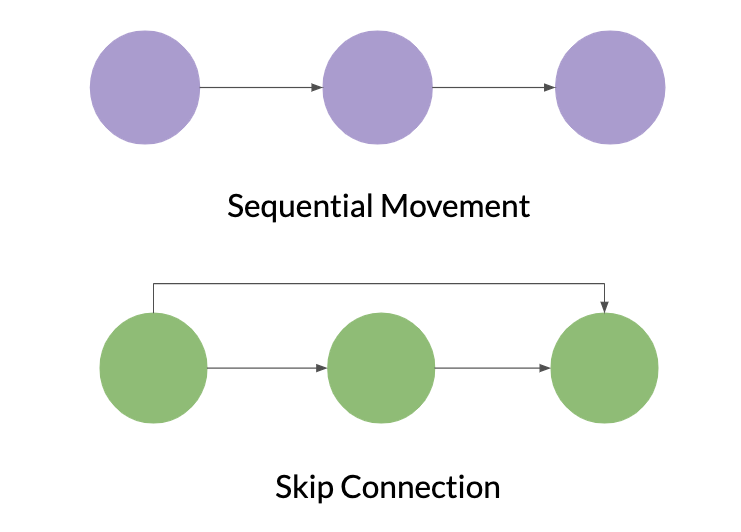

### 4.1 - Load the SIGNS Dataset
    As a reminder, the SIGNS dataset is a collection of 6 signs representing numbers from 0 to 5.

In [110]:
def load_signs_dataset():
    train_data_orig = h5py.File("./data/train_signs.h5", "r")
    train_data_X = np.array(train_data_orig["train_set_x"]) #not converting to array will give dataset of type <class 'h5py._hl.dataset.Dataset'>
    train_data_Y = np.array(train_data_orig["train_set_y"])
    train_data_Y = train_data_Y.reshape((1, train_data_Y.shape[0])) #teshaping Y
    
    test_data_orig = h5py.File("./data/test_signs.h5", "r")
    test_data_X = np.array(test_data_orig["test_set_x"])
    test_data_Y = np.array(test_data_orig["test_set_y"])
    test_data_Y = test_data_Y.reshape((1, test_data_Y.shape[0])) #reshaping Y
    
    classes = np.array(test_data_orig["list_classes"])
    
    return train_data_X, train_data_Y, test_data_X, test_data_Y, classes
    
    
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_signs_dataset()

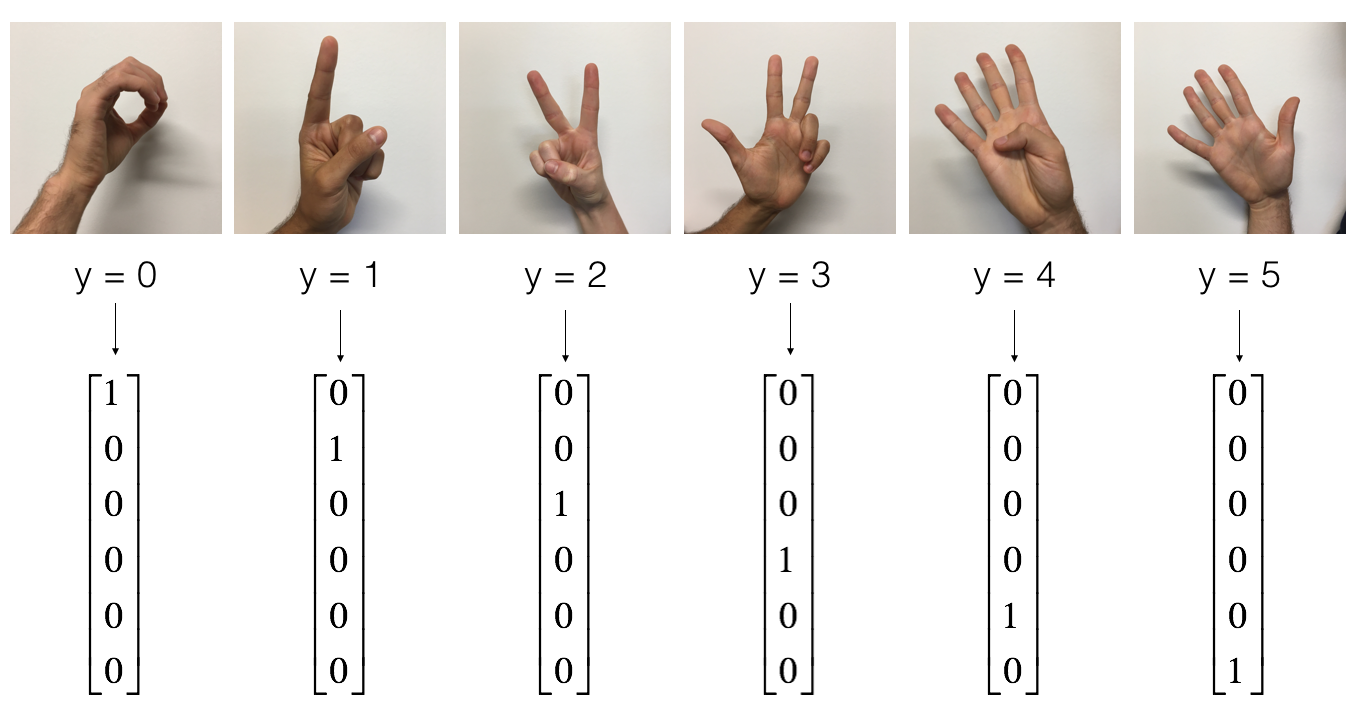    

    The next cell will show you an example of a labelled image in the dataset. Feel free to change the value of index below and re-run to see different examples.

In [106]:
print(classes)
print(Y_train_orig.shape)

[0 1 2 3 4 5]
(1, 1080)


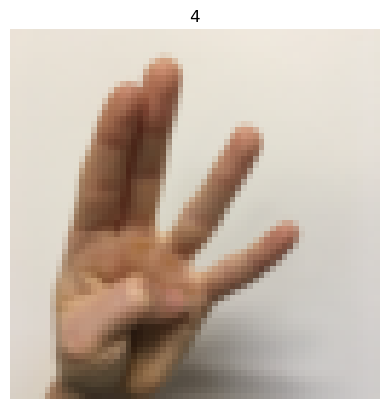

In [99]:
idx = 9

plt.imshow(X_train_orig[idx])
plt.title(f"{np.squeeze(Y_train_orig[:, idx])}")
plt.axis("off")
plt.show()

### 4.2 - Split the Data into Train/Test Sets
    In Course 2, you built a fully-connected network for this dataset. But since this is an image dataset, it is more natural to apply a ConvNet to it.

    To get started, let's examine the shapes of your data.

In [149]:
#Preprocessing
X_train = X_train_orig / 255.0
X_test = X_test_orig / 255.0
num_classes = len(classes)

#Reshaping Y one hot for categorical cross entropy and in tf shape (C, m), this way gives tf eagertensors
# Y_train = tf.one_hot(Y_train_orig.reshape((Y_train_orig.shape[1])), depth=num_classes, axis=1)
# Y_test = tf.one_hot(Y_test_orig.reshape(-1), depth=num_classes, axis=1)


#same operation with numpy np.eye() and returns numpy arrays
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

Y_train = convert_to_one_hot(Y_train_orig, num_classes).T #Tanspose does (1, 1080) - (1080, 1) and convert_to_one_hot does (1080, 6)
Y_test = convert_to_one_hot(Y_test_orig, num_classes).T

In [124]:
#Some explanation on convert_to_one_hot
def convert_to_one_hot(Y, C):
    print(np.eye(C))
    print(Y.reshape(-1).shape)
    print(Y.reshape(-1).T.shape)
    print(np.eye(C)[Y])
    print(np.eye(C)[Y.reshape(-1)].shape)
    print(np.eye(C)[Y.reshape(-1)].T.shape)
    
convert_to_one_hot(Y_train_orig, C=6)

[[1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1.]]
(1080,)
(1080,)
[[[0. 0. 0. 0. 0. 1.]
  [1. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0.]
  ...
  [0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0.]
  [0. 0. 0. 0. 0. 1.]]]
(1080, 6)
(6, 1080)


In [150]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
print(type(Y_train))

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)
<class 'numpy.ndarray'>


### 4.3 - Forward Propagation
    In TensorFlow, there are built-in functions that implement the convolution steps for you. By now, you should be familiar with how TensorFlow builds computational graphs. In the Functional API, you create a graph of layers. This is what allows such great flexibility.

    However, the following model could also be defined using the Sequential API since the information flow is on a single line. But don't deviate. What we want you to learn is to use the functional API.

    Begin building your graph of layers by creating an input node that functions as a callable object:

        
- input_img = tf.keras.Input(shape=input_shape):
            
        Then, create a new node in the graph of layers by calling a layer on the input_img object:

- tf.keras.layers.Conv2D(filters= ... , kernel_size= ... , padding='same')(input_img): 

        Read the full documentation on Conv2D. 
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D

- tf.keras.layers.MaxPool2D(pool_size=(f, f), strides=(s, s), padding='same'): 

        MaxPool2D() downsamples your input using a window of size (f, f) and strides of size (s, s) to carry out max pooling over each window. For max pooling, you usually operate on a single example at a time and a single channel at a time.
        
        Read the full documentation on MaxPool2D.
https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D

- tf.keras.layers.ReLU(): 

        computes the elementwise ReLU of Z (which can be any shape). 
    
        You can read the full documentation on ReLU.
https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU

- tf.keras.layers.Flatten(): given a tensor "P"

        this function takes each training (or test) example in the batch and flattens it into a 1D vector. If a tensor P has the shape (batch_size, h, w, c), it returns a flattened tensor with shape (batch_size, k), where "k" equals the product of all the dimension sizes other than the first dimension. For example, given a tensor with dimensions [100, 2, 3, 4], it flattens the tensor to be of shape [100, 24], where 24 = 2 * 3 * 4. 
        
        You can read the full documentation on Flatten.
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten

- tf.keras.layers.Dense(units= ... , activation='softmax')(F): 

        given the flattened input F, it returns the output computed using a fully connected layer. 

        You can read the full documentation on Dense.
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense

    In the last function above (tf.keras.layers.Dense()), the fully connected layer automatically initializes weights in the graph and keeps on training them as you train the model. Hence, you did not need to initialize those weights when initializing the parameters.

    Lastly, before creating the model, you'll need to define the output using the last of the function's compositions (in this example, a Dense layer):

- outputs = tf.keras.layers.Dense(units=6, activation='softmax')(F)

**Window, kernel, filter, pool**

    The words "kernel" and "filter" are used to refer to the same thing. The word "filter" accounts for the amount of "kernels" that will be used in a single convolution layer. "Pool" is the name of the operation that takes the max or average value of the kernels.

    This is why the parameter pool_size refers to kernel_size, and you use (f, f) to refer to the filter size.

    Pool size and kernel size refer to the same thing in different objects - They refer to the shape of the window where the operation takes place.

### Exercise 2 - convolutional_model
    Implement the convolutional_model function below to build the following model: CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE. Use the functions above!

    Also, plug in the following parameters for all the steps:

        - Conv2D: Use 8 4x4 filters, stride 1, padding is "SAME"
        - ReLU
        - MaxPool2D: Use an 8x8 filter size and an 8x8 stride, padding is "SAME"
        - Conv2D: Use 16 2 by 2 filters, stride 1, padding is "SAME"
        - ReLU
        - MaxPool2D: Use a 4x4 filter size and a 4x4 stride, padding is "SAME"
        - Flatten the previous output.
        - Fully-connected (Dense) layer: Apply a fully connected layer with 6 neurons and a softmax activation.

In [163]:
import tensorflow.keras.layers as tfl

def convolutional_model(input_shape):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE
    
    Note that for simplicity purposes, you'll hard-code some values
    such as the stride and kernel (filter) sizes. 
    Normally, functions should take these values as function parameters.
    
    Arguments:
    input_img -- input dataset, of shape (input_shape)

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """
    input_img = tf.keras.Input(shape=input_shape)
    
    # CONV2D: 8 filters 4x4, stride of 1, padding 'SAME'
    Z1 = tfl.Conv2D(filters=8, kernel_size=4, strides=1, padding="SAME")(input_img)
    
    # RELU
    A1 = tfl.ReLU()(Z1)
    
    # MAXPOOL: window 8x8, stride 8, padding 'SAME'
    P1 = tfl.MaxPooling2D(pool_size=(8, 8), strides=(8, 8), padding="SAME")(A1)
    
    # CONV2D: 16 filters 2x2, stride 1, padding 'SAME'
    Z2 = tfl.Conv2D(filters=16, kernel_size=2, strides=1, padding="SAME")(P1)
    
    # RELU
    A2 = tfl.ReLU()(Z2)
    
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tfl.MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding="SAME")(A2)
    
    # FLATTEN
    F = tfl.Flatten()(P2)
    
    # Dense layer - 6 neurons in output layer, "activation='softmax'" 
    output = tfl.Dense(6, activation="softmax")(F)
    
    #Keras functional API Model
    model = tf.keras.Model(inputs=input_img, outputs=output, name="FunctionAPIConvModel")
    return model           

In [164]:
conv_model = convolutional_model((64, 64, 3))
conv_model.compile(optimizer="adam", 
                  loss="categorical_crossentropy",
                  metrics="accuracy")
conv_model.summary()

Model: "FunctionAPIConvModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 8)         392       
                                                                 
 re_lu_11 (ReLU)             (None, 64, 64, 8)         0         
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 8, 8, 8)           0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 8, 8, 16)          528       
                                                                 
 re_lu_12 (ReLU)             (None, 8, 8, 16)          0         
                                              

In [156]:
#test the model summary using - comparator
output = [['InputLayer', [(None, 64, 64, 3)], 0],
        ['Conv2D', (None, 64, 64, 8), 392, 'same', 'linear', 'GlorotUniform'],
        ['ReLU', (None, 64, 64, 8), 0],
        ['MaxPooling2D', (None, 8, 8, 8), 0, (8, 8), (8, 8), 'same'],
        ['Conv2D', (None, 8, 8, 16), 528, 'same', 'linear', 'GlorotUniform'],
        ['ReLU', (None, 8, 8, 16), 0],
        ['MaxPooling2D', (None, 2, 2, 16), 0, (4, 4), (4, 4), 'same'],
        ['Flatten', (None, 64), 0],
        ['Dense', (None, 6), 390, 'softmax']]

def comparator(learner, instructor):
    if learner == instructor:
        for a, b in zip(learner, instructor):
            if tuple(a) != tuple(b):
                print(colored("Test failed", attrs=['bold']),
                      "\n Expected value \n\n", colored(f"{b}", "green"), 
                      "\n\n does not match the input value: \n\n", 
                      colored(f"{a}", "red"))
                raise AssertionError("Error in test") 
        print(colored("All tests passed!", "green"))
        
    else:
        print(colored("Test failed. Your output is not as expected output.", "red"))
    
comparator(summary(conv_model), output)

All tests passed!


    Both the Sequential and Functional APIs return a TF Keras model object. The only difference is how inputs are handled inside the object model!

### 4.4 - Train the Model

In [165]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)
history = conv_model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Epoch 1/100
17/17 [==============================] - 2s 52ms/step - loss: 1.8148 - accuracy: 0.1704 - val_loss: 1.7962 - val_accuracy: 0.1583
Epoch 2/100
17/17 [==============================] - 1s 43ms/step - loss: 1.7908 - accuracy: 0.1667 - val_loss: 1.7906 - val_accuracy: 0.1750
Epoch 3/100
17/17 [==============================] - 1s 42ms/step - loss: 1.7859 - accuracy: 0.2019 - val_loss: 1.7857 - val_accuracy: 0.1500
Epoch 4/100
17/17 [==============================] - 1s 39ms/step - loss: 1.7795 - accuracy: 0.2139 - val_loss: 1.7789 - val_accuracy: 0.2333
Epoch 5/100
17/17 [==============================] - 1s 40ms/step - loss: 1.7702 - accuracy: 0.3046 - val_loss: 1.7710 - val_accuracy: 0.2583
Epoch 6/100
17/17 [==============================] - 1s 39ms/step - loss: 1.7575 - accuracy: 0.3139 - val_loss: 1.7613 - val_accuracy: 0.2917
Epoch 7/100
17/17 [==============================] - 1s 39ms/step - loss: 1.7411 - accuracy: 0.3481 - val_loss: 1.7468 - val_accuracy: 0.3500
Epoch 

### 5 - History Object
    The history object is an output of the .fit() operation, and provides a record of all the loss and metric values in memory. It's stored as a dictionary that you can retrieve at history.history:

In [166]:
history.history

{'loss': [1.8147881031036377,
  1.7907830476760864,
  1.7859348058700562,
  1.7794517278671265,
  1.7701647281646729,
  1.7575006484985352,
  1.7410507202148438,
  1.7175551652908325,
  1.6886050701141357,
  1.6527390480041504,
  1.6094309091567993,
  1.5591603517532349,
  1.5048710107803345,
  1.4520906209945679,
  1.403795599937439,
  1.356024146080017,
  1.3120293617248535,
  1.2718249559402466,
  1.233900785446167,
  1.1980876922607422,
  1.1638085842132568,
  1.1323455572128296,
  1.1021963357925415,
  1.073574423789978,
  1.0456243753433228,
  1.0189640522003174,
  0.992989182472229,
  0.9689379930496216,
  0.9457934498786926,
  0.9241485595703125,
  0.9033612608909607,
  0.883418083190918,
  0.8642197251319885,
  0.8462434411048889,
  0.8285111784934998,
  0.8121950626373291,
  0.7964227199554443,
  0.7812747359275818,
  0.7663721442222595,
  0.7514647841453552,
  0.7379819750785828,
  0.7244769930839539,
  0.7116701602935791,
  0.6992961168289185,
  0.6876738667488098,
  0.6760

    Now visualize the loss over time using history.history:

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

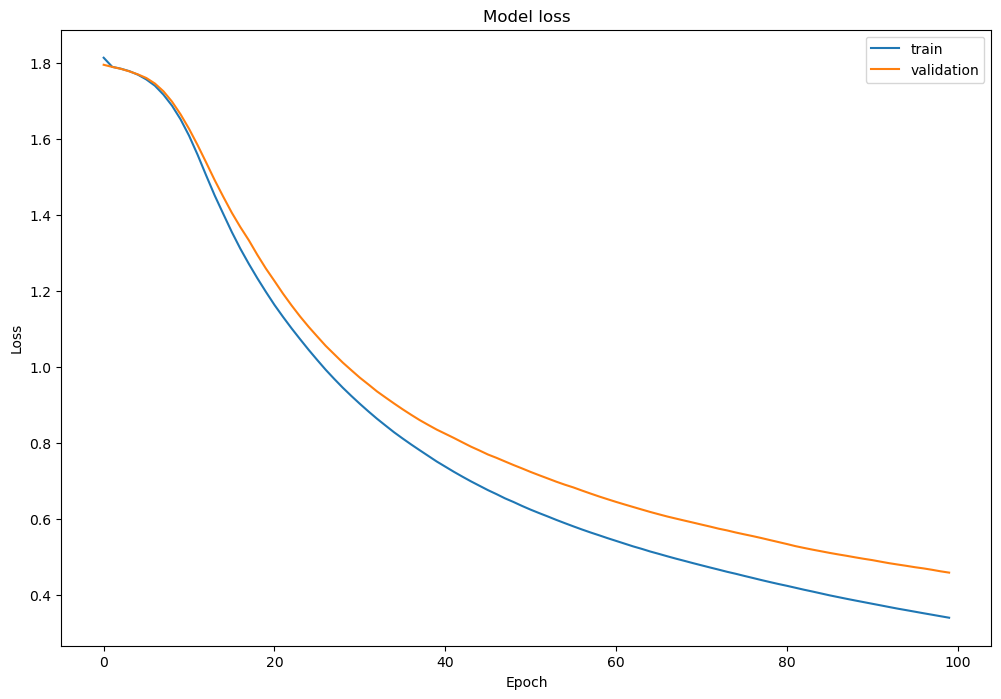

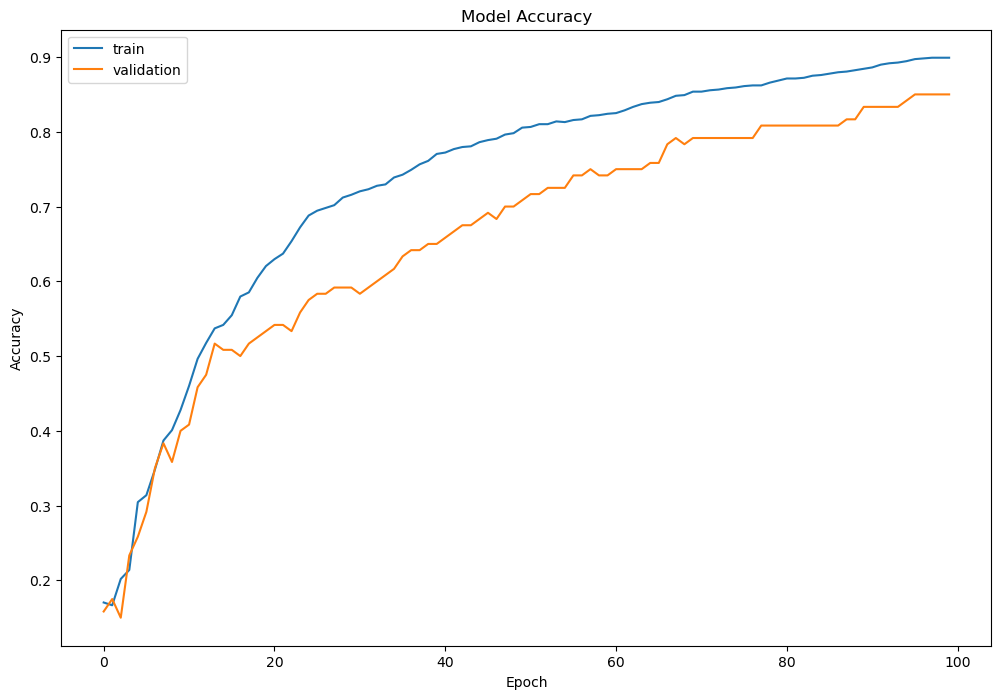

In [167]:
# The history.history["loss"] entry is a dictionary with as many values as epochs that the
# model was trained on. 
df_loss_acc = pd.DataFrame(history.history)

df_loss= df_loss_acc[['loss', 'val_loss']]
df_loss.columns = ['train', 'validation']
# df_loss.rename(columns={'loss':'train','val_loss':'validation'}, inplace=True)

df_acc= df_loss_acc[['accuracy', 'val_accuracy']]
# df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'}, inplace=True)
df_acc.columns = ['train', 'validation']

df_loss.plot(title='Model loss', figsize=(12, 8)).set(xlabel='Epoch', ylabel='Loss')
df_acc.plot(title='Model Accuracy', figsize=(12, 8)).set(xlabel='Epoch', ylabel='Accuracy')

    Congratulations! You've finished the assignment and built two models: One that recognizes smiles, and another that recognizes SIGN language with almost 80% accuracy on the test set. In addition to that, you now also understand the applications of two Keras APIs: Sequential and Functional. Nicely done!

    By now, you know a bit about how the Functional API works and may have glimpsed the possibilities. In your next assignment, you'll really get a feel for its power when you get the opportunity to build a very deep ConvNet, using ResNets!


### 6 - Bibliography
    You're always encouraged to read the official documentation. To that end, you can find the docs for the Sequential and Functional APIs here:

https://www.tensorflow.org/guide/keras/sequential_model

https://www.tensorflow.org/guide/keras/functional

In [32]:
#Self Practice
import tensorflow as tf
import tensorflow.keras.layers as tfl
import numpy as np
import h5py

def load_faces_data():
    train_data = h5py.File("./data/train_happy.h5", "r")
    test_data = h5py.File("./data/test_happy.h5", "r")
    X_train_orig = np.array(train_data["train_set_x"])
    Y_train_orig = np.array(train_data["train_set_y"])
    Y_train_orig = Y_train_orig.reshape(1, Y_train_orig.shape[0])
    
    X_test_orig = np.array(test_data["test_set_x"])
    Y_test_orig = np.array(test_data["test_set_y"])
    Y_test_orig = Y_test_orig.reshape(1, Y_test_orig.shape[0])
    classes = np.array(test_data["list_classes"])
    
    return X_train_orig, X_test_orig, Y_train_orig, Y_test_orig, classes

X_train_orig, X_test_orig, Y_train_orig, Y_test_orig, classes = load_faces_data()

print("Training data")
print(X_train_orig.shape)
print(Y_train_orig.shape)
print("Test data")
print(X_test_orig.shape)
print(Y_test_orig.shape)

#normalizing X
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

#reshaping y as per tf
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T
print(Y_train.shape)
print(Y_test.shape)

#Sequential model building
def happyModel():
    model = tf.keras.Sequential([
        tfl.Input(shape=(64, 64, 3)),
        tfl.ZeroPadding2D(padding=3),
        tfl.Conv2D(filters=32, kernel_size=7, strides=1),
        tfl.BatchNormalization(axis=3, momentum=0.99, epsilon=0.001),
        tfl.ReLU(),
        tfl.MaxPool2D(pool_size=(2, 2), strides=2, padding="valid"),
        tfl.Flatten(),
        tfl.Dense(1, activation="sigmoid")
    ], name="sequentialmodel")
    return model

happy_model = happyModel()

#compilation and summary
happy_model.compile(optimizer="adam",
                    loss="binary_crossentropy",
                    metrics=["accuracy"])

#some usueful model accessible variables
print(happy_model.layers)
print(happy_model.output_shape)
print(happy_model.count_params())

for l in happy_model.layers:
    print(l.__class__.__name__)
    print(l.count_params())

#summary
print(happy_model.summary())
    
#training and evauation
happy_model.fit(X_train, Y_train, epochs=10, batch_size=16)

happy_model.evaluate(X_test, Y_test)

Training data
(600, 64, 64, 3)
(1, 600)
Test data
(150, 64, 64, 3)
(1, 150)
(600, 1)
(150, 1)
[<keras.src.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x0000022384827D30>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x00000223EC622A60>, <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x00000223EC6220D0>, <keras.src.layers.activation.relu.ReLU object at 0x00000223EC622370>, <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x00000223EC622D90>, <keras.src.layers.reshaping.flatten.Flatten object at 0x00000223EC60F2E0>, <keras.src.layers.core.dense.Dense object at 0x00000223EC60F070>]
(None, 1)
37633
ZeroPadding2D
0
Conv2D
4736
BatchNormalization
128
ReLU
0
MaxPooling2D
0
Flatten
0
Dense
32769
Model: "sequentialmodel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d_18 (ZeroPad  (None, 70, 70, 3)         0         
 ding2D) 

[0.4171738624572754, 0.8066666722297668]

In [48]:
#Self Practice
import tensorflow as tf
import tensorflow.keras.layers as tfl
import numpy as np
import h5py
tf.random.set_seed(1234)

def load_signs_data():
    train_data = h5py.File("./data/train_signs.h5", "r")
    test_data = h5py.File("./data/test_signs.h5", "r")
    X_train_orig = np.array(train_data["train_set_x"])
    Y_train_orig = np.array(train_data["train_set_y"])
    Y_train_orig = Y_train_orig.reshape(1, Y_train_orig.shape[0])
    
    X_test_orig = np.array(test_data["test_set_x"])
    Y_test_orig = np.array(test_data["test_set_y"])
    Y_test_orig = Y_test_orig.reshape(1, Y_test_orig.shape[0])
    classes = np.array(test_data["list_classes"])
    
    return X_train_orig, X_test_orig, Y_train_orig, Y_test_orig, classes

X_train_orig, X_test_orig, Y_train_orig, Y_test_orig, classes = load_signs_data()

print("Training data")
print(X_train_orig.shape)
print(Y_train_orig.shape)
print("Test data")
print(X_test_orig.shape)
print(Y_test_orig.shape)

#normalizing X
X_train = X_train_orig / 255.
X_test = X_test_orig / 255.

#one hot encoding for categorical one hot values
def convert_one_hot(Y, C):
    Y_onehot = np.eye(C)[Y.reshape(-1)].T
#     print(np.eye(6)[np.array([5, 4, 3])])
    return Y_onehot
Y_train = convert_one_hot(Y_train_orig, len(classes))
Y_test = convert_one_hot(Y_test_orig, len(classes))
print(Y_train.shape)
print(Y_test.shape)

#reshaping y as per tf
Y_train = Y_train.T
Y_test = Y_test.T
print(Y_train.shape)
print(Y_test.shape)


#Sequential model building
def signsModel(inputshape):
    inputs = tf.keras.Input(shape=inputshape)
    Z1 = tfl.Conv2D(filters=8, kernel_size=4, padding="same", strides=1)(inputs)
    A1 = tfl.ReLU()(Z1)
    P1 = tfl.MaxPool2D(pool_size=8, strides=8, padding="SAME")(A1)
    Z2 = tfl.Conv2D(filters= 16., kernel_size=2, padding="same", strides=1)(P1)
    A2 = tfl.ReLU()(Z2)
    P2 = tfl.MaxPool2D(pool_size=4, strides=4, padding="SAME")(A2)
    F3 = tfl.Flatten()(P2)
    outputs = tfl.Dense(6, activation="softmax")(F3)
    model = tf.keras.Model(inputs, outputs, name="functionalmodel")
    
    return model

model = signsModel(X_train[0].shape)

#compilation and summary
model.compile(optimizer="adam",
               loss="categorical_crossentropy",
               metrics=["accuracy"])

#some usueful model accessible variables
print(model.layers)
print(model.output_shape)
print(model.count_params())

for l in model.layers:
    print(l.__class__.__name__)
    print(l.count_params())

#summary
print(model.summary())
    
#training and evauation of model using tensor slices
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test)).batch(64)
history = model.fit(train_dataset, epochs=100, validation_data=test_dataset)

Training data
(1080, 64, 64, 3)
(1, 1080)
Test data
(120, 64, 64, 3)
(1, 120)
(6, 1080)
(6, 120)
(1080, 6)
(120, 6)
[<keras.src.engine.input_layer.InputLayer object at 0x00000223838A35E0>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x0000022383A5B250>, <keras.src.layers.activation.relu.ReLU object at 0x0000022383A5BAF0>, <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x00000223840EDCA0>, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x0000022383A7C7C0>, <keras.src.layers.activation.relu.ReLU object at 0x00000223840ED4C0>, <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x00000223840DA340>, <keras.src.layers.reshaping.flatten.Flatten object at 0x0000022383C83700>, <keras.src.layers.core.dense.Dense object at 0x0000022383C83520>]
(None, 6)
1310
InputLayer
0
Conv2D
392
ReLU
0
MaxPooling2D
0
Conv2D
528
ReLU
0
MaxPooling2D
0
Flatten
0
Dense
390
Model: "functionalmodel"
_________________________________________________________________
 La

17/17 [==============================] - 1s 35ms/step - loss: 0.9154 - accuracy: 0.6537 - val_loss: 0.9259 - val_accuracy: 0.6500
Epoch 40/100
17/17 [==============================] - 1s 35ms/step - loss: 0.9001 - accuracy: 0.6583 - val_loss: 0.9132 - val_accuracy: 0.6333
Epoch 41/100
17/17 [==============================] - 1s 33ms/step - loss: 0.8881 - accuracy: 0.6611 - val_loss: 0.9024 - val_accuracy: 0.6583
Epoch 42/100
17/17 [==============================] - 1s 33ms/step - loss: 0.8746 - accuracy: 0.6630 - val_loss: 0.8887 - val_accuracy: 0.6500
Epoch 43/100
17/17 [==============================] - 1s 33ms/step - loss: 0.8608 - accuracy: 0.6741 - val_loss: 0.8760 - val_accuracy: 0.6583
Epoch 44/100
17/17 [==============================] - 1s 32ms/step - loss: 0.8478 - accuracy: 0.6861 - val_loss: 0.8641 - val_accuracy: 0.6750
Epoch 45/100
17/17 [==============================] - 1s 37ms/step - loss: 0.8353 - accuracy: 0.6917 - val_loss: 0.8530 - val_accuracy: 0.7000
Epoch 46/100

17/17 [==============================] - 1s 34ms/step - loss: 0.4960 - accuracy: 0.8324 - val_loss: 0.5849 - val_accuracy: 0.7583
Epoch 97/100
17/17 [==============================] - 1s 33ms/step - loss: 0.4920 - accuracy: 0.8324 - val_loss: 0.5819 - val_accuracy: 0.7667
Epoch 98/100
17/17 [==============================] - 1s 32ms/step - loss: 0.4881 - accuracy: 0.8333 - val_loss: 0.5795 - val_accuracy: 0.7667
Epoch 99/100
17/17 [==============================] - 1s 32ms/step - loss: 0.4841 - accuracy: 0.8333 - val_loss: 0.5767 - val_accuracy: 0.7583
Epoch 100/100
17/17 [==============================] - 1s 32ms/step - loss: 0.4802 - accuracy: 0.8343 - val_loss: 0.5741 - val_accuracy: 0.7583


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
Index(['loss', 'accuracy', 'val_loss', 'val_accuracy'], dtype='object')


[Text(0.5, 0, 'epoch'), Text(0, 0.5, 'Accuracy')]

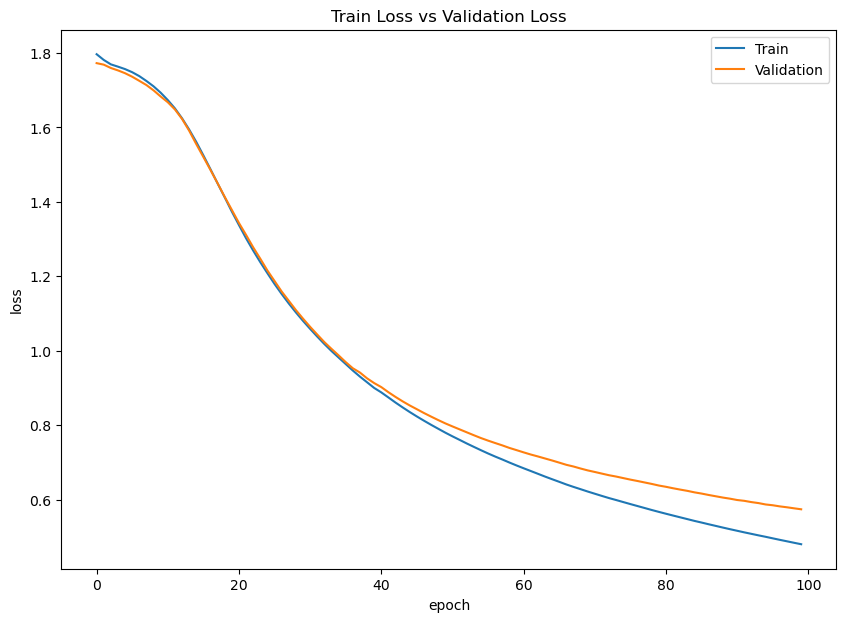

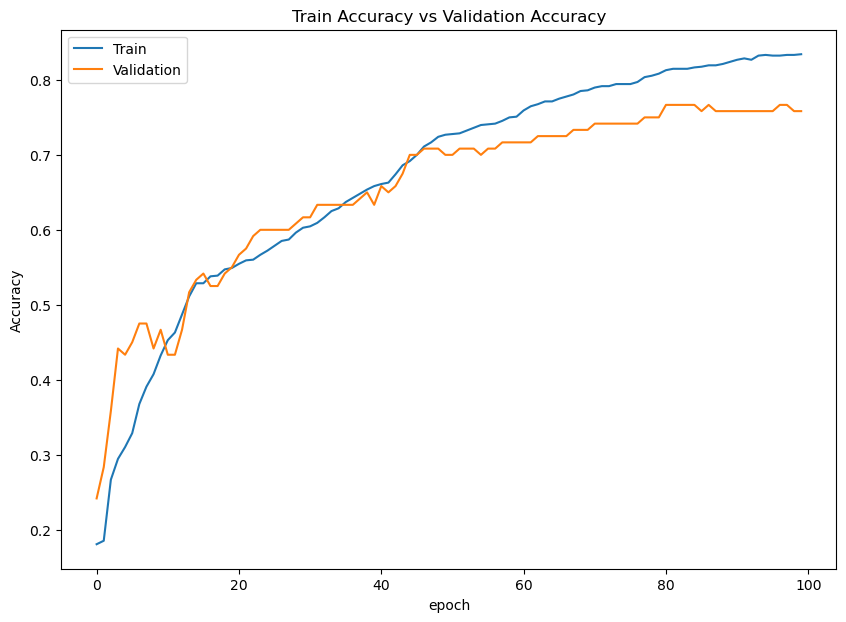

In [56]:
#plotting
import pandas as pd
print(history.history.keys())
df_history = pd.DataFrame(history.history)
print(df_history.columns)
df_loss = df_history[["loss", "val_loss"]]
df_acc = df_history[["accuracy", "val_accuracy"]]

df_loss.columns = ["Train", "Validation"]
df_acc.columns = ["Train", "Validation"]

df_loss.plot(title="Train Loss vs Validation Loss", figsize=(10, 7)).set(xlabel="epoch", ylabel="loss")
df_acc.plot(title="Train Accuracy vs Validation Accuracy", figsize=(10, 7)).set(xlabel="epoch", ylabel="Accuracy")